In [1]:
SensorNum=2 # Sensor number
WindowWidth=[16,32,64,128,256,512,1024] # Window Width
OverlapArray=[4,8,16,32,64,128,256] # sliding window
width=3000 # graph width 
EncodingDim=[4,8,12,16,32,64] # number of hidden layer note
Axis='AccZ' # Axis

# chopin
#WORKSPACE_PATH = "/media/takeyama/HD-PZU3/01_TAKEYAMA_WORKSPACE/02_CommonData/2016-07-25"

# mozart
WORKSPACE_PATH = "/home/takeyama/Documents/01_SyncChopin"

In [2]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import datetime
import multiprocessing as mp
import processing

%matplotlib inline

In [3]:
DataName='sensor'+str(SensorNum)+'_'+Axis
SensorName='sensor'+str(SensorNum)
DicName='MemSensor'+str(SensorNum)

In [4]:
if not os.path.exists(WORKSPACE_PATH+'/study/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/study/'+DataName+'/')
StudyDataPath=WORKSPACE_PATH+'/study/'+DataName+'/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/loss/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/loss/')
GraphDataPath=WORKSPACE_PATH+'/graph/'+DataName+'/loss/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/Time/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/Time/')
GraphDataTimePath=WORKSPACE_PATH+'/graph/'+DataName+'/Time/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum/')
GraphDataSpectrumPath=WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum/'

if not os.path.exists(WORKSPACE_PATH+'/modelPic/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/modelPic/'+DataName+'/')
StudyDataModelPicPath=WORKSPACE_PATH+'/modelPic/'+DataName+'/'

if not os.path.exists(WORKSPACE_PATH+'/window/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/window/'+DataName+'/')
WindowDataPath=WORKSPACE_PATH+'/window/'+DataName+'/'

RawDataPath=WORKSPACE_PATH+"raw/"

In [5]:
def kld(p, q):
    """Calculates Kullback–Leibler divergence"""
    p = np.array(p)
    q = np.array(q)
    return np.sum(p * np.log(p / q), axis=(p.ndim - 1))
 
def jsd(p, q):
    """Calculates Jensen-Shannon Divergence"""
    p = np.array(p)
    q = np.array(q)
    m = 0.5 * (p + q)
    return 0.5 * kld(p, m) + 0.5 * kld(q, m)

hiden node = 4


/home/takeyama/.pyenv/versions/takeyama/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Graph range=0 : 3184
Graph range=3184 : 6368
Graph range=6368 : 9552
Graph range=9552 : 12736
Graph range=12736 : 15920
Graph range=15920 : 19104
Graph range=19104 : 22288
Graph range=22288 : 25472
Graph range=25472 : 28656
Graph range=28656 : 31840
Graph range=31840 : 35024
Graph range=35024 : 38208
Graph range=38208 : 41392
Graph range=41392 : 44576
Graph range=44576 : 47760
Graph range=47760 : 50944
Graph range=50944 : 54128
Graph range=54128 : 57312
Graph range=57312 : 60496
Graph range=60496 : 63680
hiden node = 8
Graph range=0 : 3184
Graph range=3184 : 6368
Graph range=6368 : 9552
Graph range=9552 : 12736
Graph range=12736 : 15920
Graph range=15920 : 19104
Graph range=19104 : 22288
Graph range=22288 : 25472
Graph range=25472 : 28656
Graph range=28656 : 31840
Graph range=31840 : 35024
Graph range=35024 : 38208
Graph range=38208 : 41392
Graph range=41392 : 44576
Graph range=44576 : 47760
Graph range=47760 : 50944
Graph range=50944 : 54128
Graph range=54128 : 57312
Graph range=57312

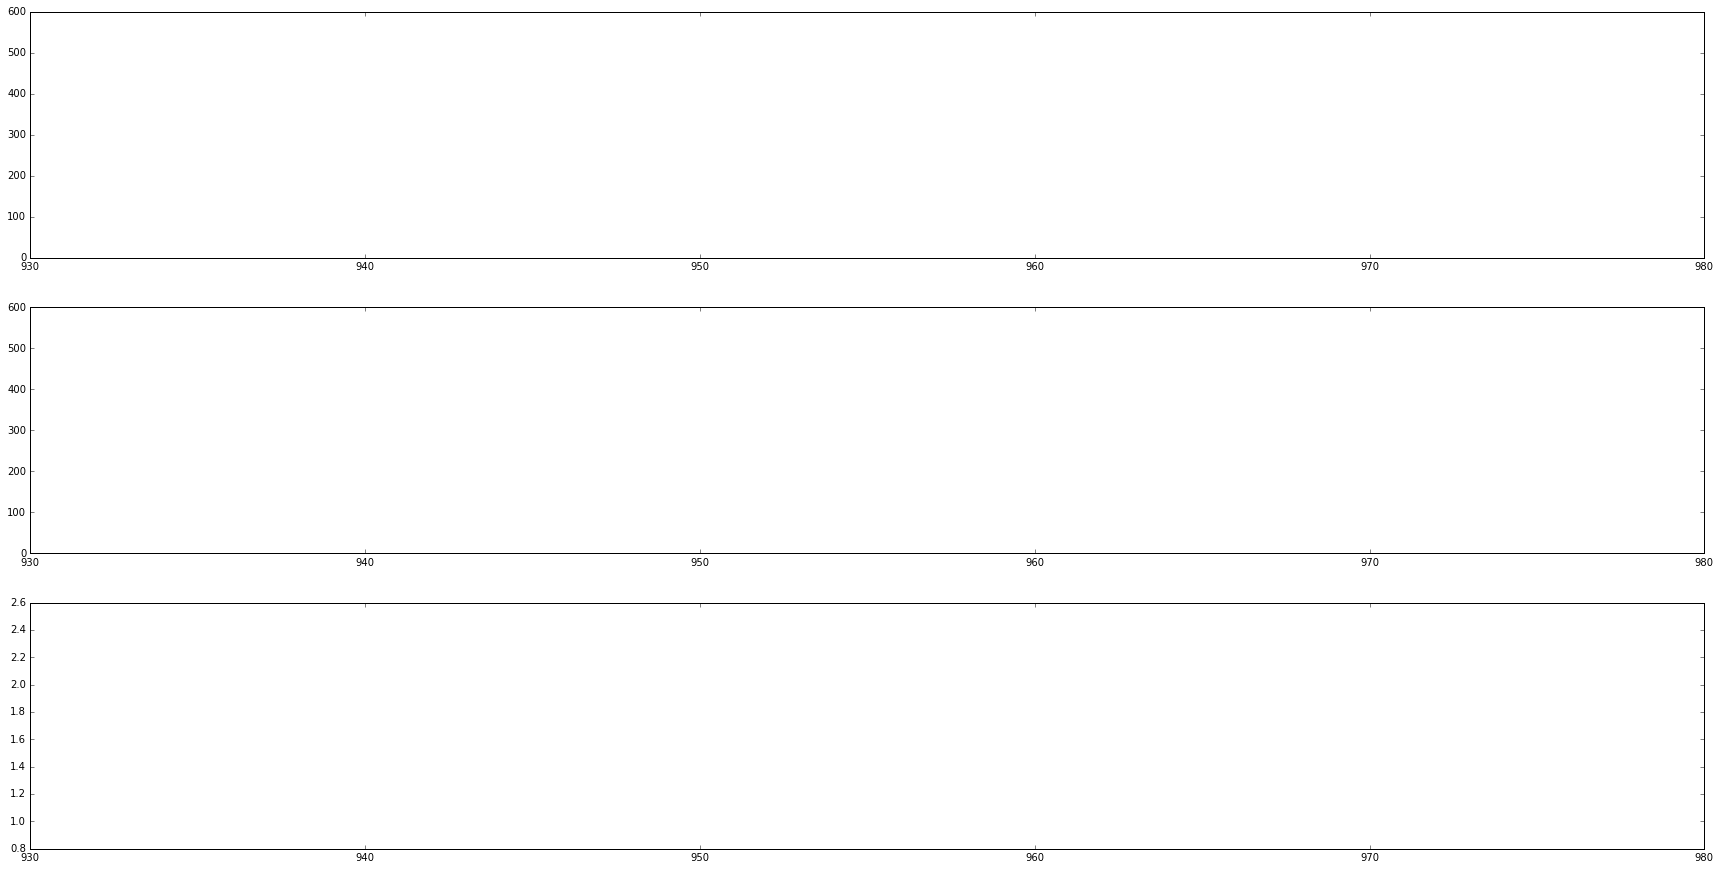

In [6]:
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
bx = fig.add_subplot(312)
cx = fig.add_subplot(313)

# loop windowWidth
for SampleNum,Overlap in zip(WindowWidth,OverlapArray):
    # define SaveFileName
    for encoding_dim in EncodingDim:
        print "hiden node = "+str(encoding_dim)
        CommonName = '_edim='+str(encoding_dim)+'-Window='+str(SampleNum)+'-Overlap='+str(Overlap*100)
        SaveFileNameEncord=DataName+'_encoded'+ CommonName
        SaveFileNameDecord=DataName+'_decoded'+ CommonName
        SaveFileNameNet=DataName+'_net'+ CommonName
        SaveFileNameTrain=DataName+'_train'+ CommonName
        SaveFileNameTest=DataName+'_test'+ CommonName
        SaveFileNameGraph= GraphDataSpectrumPath+DataName+CommonName

        #window = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameTrain)
        window = processing.LoadDicDataFromFileNPZ(WindowDataPath+SaveFileNameTrain)
        reconstructData = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameDecord)
        
        # FFT 
        fftDataE = np.array([])
        fftDataD = np.array([])
        for i in range(len(window)):
                fftDataE=np.append(fftDataE, fftpack.fft( window[i])[1:(SampleNum/2)+1])
                fftDataD=np.append(fftDataD, fftpack.fft( reconstructData[i])[1:(SampleNum/2)+1])
        fftDataE = fftDataE.reshape(len(fftDataE)/(SampleNum/2),(SampleNum/2))
        fftDataD = fftDataD.reshape(len(fftDataD)/(SampleNum/2),(SampleNum/2))
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-fft-raw',fftDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-fft-restruct',fftDataD)
        
        # Power
        PowerDataE = np.imag(fftDataE)**2+np.real(fftDataE)**2
        PowerDataD = np.imag(fftDataD)**2+np.real(fftDataD)**2
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-power-raw',PowerDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-power-restruct',PowerDataD)
        
        # to distribution
        DistributePowerDataE = np.array([])
        DistributePowerDataD = np.array([])

        for i in range( PowerDataE.shape[0] ):
            DistributePowerDataE = np.append(DistributePowerDataE,PowerDataE[i]/( np.sum(PowerDataE[i]) ))
        DistributePowerDataE = DistributePowerDataE.reshape(PowerDataE.shape)

        for i in range( PowerDataD.shape[0] ):
            DistributePowerDataD = np.append(DistributePowerDataD,PowerDataD[i]/( np.sum(PowerDataD[i]) ))
        DistributePowerDataD = DistributePowerDataD.reshape(PowerDataD.shape)

        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-power-distribution-raw',DistributePowerDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-power-distribution-reconst',DistributePowerDataD)

        # Kullback-leibler-divergence plot
        ArrayKLD = np.array([])
        for i in range(DistributePowerDataE.shape[0]):
            ArrayKLD = np.append(ArrayKLD, kld(DistributePowerDataE[i],DistributePowerDataD[i]))
        
        width = DistributePowerDataE.shape[0]/20
        for i in range(width,DistributePowerDataE.shape[0],width):
            start =i-width
            goal=i

            data = ArrayKLD[start:goal]
            dataE = DistributePowerDataE[start:goal]
            dataD = DistributePowerDataD[start:goal]

            #dataE,dataDをPower
            ax.pcolormesh(range(start,goal),range(dataE.shape[1]),dataE.T ,label='rawData')
            ax.legend(loc='best')
            ax.set_title(str(start)+"-"+str(goal))

            bx.pcolormesh(range(start,goal),range(dataD.shape[1]),dataD.T ,label='reconst' )
            bx.legend(loc='best')
            bx.set_title(str(start)+"-"+str(goal))

            cx.plot(range(start,goal),data,'g',label="kld data")
            cx.legend(loc='best')
            cx.set_title(str(start)+"-"+str(goal))
            ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-'+'-glaph')
            ax.clear()
            bx.clear()
            cx.clear()
            print 'Graph range='+str(start)+' : '+str(goal)
            time.sleep(3)